In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils.class_weight import compute_class_weight

# Load and preprocess the dataset
df = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.sort_values(by='DATETIME')
df.set_index('DATETIME', inplace=True)

# Define features and target
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Normalize the numerical features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Function to build the model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(128))
    model.add(Dropout(0.2))
    model.add(Dense(len(features)))
    model.compile(optimizer='RMSprop', loss='mean_squared_error')
    return model

# Function to evaluate the model
def evaluate_model(train_data, test_data, time_steps):
    # Ensure there's enough data to generate a sequence
    if len(train_data) <= time_steps or len(test_data) <= time_steps:
        print("Not enough data for the specified time steps.")
        return np.inf
    
    # Create data generators
    train_gen = TimeseriesGenerator(train_data[features].values, train_data[target].values, 
                                    length=time_steps, batch_size=32)
    test_gen = TimeseriesGenerator(test_data[features].values, test_data[target].values, 
                                   length=time_steps, batch_size=32)
    
    if len(train_gen) == 0 or len(test_gen) == 0:
        print("Generator produced no data. Adjust time steps or dataset size.")
        return np.inf
    
    model = build_model((time_steps, len(features)))
    model.fit(train_gen, epochs=20, verbose=0)
    loss = model.evaluate(test_gen)
    return loss

# 1. Time Series Split Cross-Validation
def time_series_split_cv(data, time_steps, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        if len(train) < time_steps or len(test) < time_steps:
            continue
        loss = evaluate_model(train, test, time_steps)
        results.append(loss)
    return results

# Set the number of time steps
time_steps = 21

# Apply Time Series Split CV
print("Time Series Split CV Results:", time_series_split_cv(df, time_steps))


# Walk-Forward Validation Forecast Function
def forecast_weather(model, data, scaler, steps=7):
    features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
    required_timesteps = model.input_shape[1]
    
    if data.shape[0] < required_timesteps:
        raise ValueError(f"Not enough data points for the model's expected input shape of {required_timesteps}. Available data points: {data.shape[0]}.")

    last_sequence = data[-required_timesteps:].copy()
    last_sequence = last_sequence.values
    last_sequence = last_sequence[np.newaxis, :, :] 

    forecast = []
    for _ in range(steps * 3):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0])
        last_sequence = np.append(last_sequence[:, 1:, :], prediction[np.newaxis, :], axis=1)

    forecast_df = pd.DataFrame(forecast, columns=features)
    forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), columns=features)

    last_date = data.index.max()
    start_date = last_date + pd.Timedelta(days=1)
    times = ['08:00', '12:00', '16:00']
    forecast_dates = []

    for i in range(steps):
        for time in times:
            combined_datetime_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d') + ' ' + time
            forecast_dates.append(pd.Timestamp(combined_datetime_str))

    if len(forecast_dates) != len(forecast_df):
        raise ValueError(f"Length of forecast_dates ({len(forecast_dates)}) does not match length of forecast_df ({len(forecast_df)}).")

    forecast_df['DATETIME'] = forecast_dates
    return forecast_df

# Train a model using the entire dataset
final_model = build_model((time_steps, len(features)))
final_train_gen = TimeseriesGenerator(df[features].values, df[target].values, 
                                      length=time_steps, batch_size=32)
final_model.fit(final_train_gen, epochs=50)

# Generate the weather forecast
forecast_results = forecast_weather(final_model, df, scaler)
print(forecast_results)

# Save forecast results to CSV
forecast_results.to_csv('LSTM_GRU_forecast_results.csv', index=True)


2024-11-13 11:52:48.641832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:52:48.643093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:52:48.643580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 5ms/step - loss: 0.0353


2024-11-13 11:52:54.581112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:52:54.581525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:52:54.581908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 5ms/step - loss: 0.0321


2024-11-13 11:53:04.279510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:53:04.279914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:53:04.280424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 5ms/step - loss: 0.0348


2024-11-13 11:53:18.143394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:53:18.143819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:53:18.144194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 5ms/step - loss: 0.0240


2024-11-13 11:53:36.333533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:53:36.333946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:53:36.334494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 5ms/step - loss: 0.0356
Time Series Split CV Results: [0.03533893823623657, 0.032057058066129684, 0.034838829189538956, 0.023957202211022377, 0.0355529859662056]
Epoch 1/50


2024-11-13 11:53:58.408734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:53:58.409125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:53:58.409579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 2s 19ms/step - loss: 0.0531
Epoch 2/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0394
Epoch 3/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0357
Epoch 4/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0351
Epoch 5/50
60/60 [==============================] - 1s 21ms/step - loss: 0.0339
Epoch 6/50
60/60 [==============================] - 1s 24ms/step - loss: 0.0331
Epoch 7/50
60/60 [==============================] - 1s 23ms/step - loss: 0.0330
Epoch 8/50
60/60 [==============================] - 1s 21ms/step - loss: 0.0331
Epoch 9/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0324
Epoch 10/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0316
Epoch 11/50
60/60 [==============================] - 1s 20ms/step - loss: 0.0315
Epoch 12/50
60/60 [==============================] - 1s 19ms/step - loss: 0.0314
Epoch 13/50
60/60 [=============================

2024-11-13 11:54:58.709770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 11:54:58.710251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 11:54:58.710709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 9ms/step
    TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  OCCURENCE OF FLOOD  \
0          33.037075       1.522786          3.591782            0.964939   
1          34.933975       1.273469          4.891613            0.961968   
2          35.168774       1.263111          5.135427            0.957447   
3          35.286701       1.250936          5.314406            0.954709   
4          35.528225       1.169865          5.458921            0.957330   
5          35.711281       1.091909          5.517552            0.961149   
6          35.805843       1.044138          5.523118            0.963897   
7          35.848583       1.007227          5.515659            0.966401   
8          35.888023       0.977106          5.516348            0.968537   
9          35.951447       0.957489          5.528928            0.969534   
10         36.016659       0.935394          5.549906            0.970719   
11         36.070244     

Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


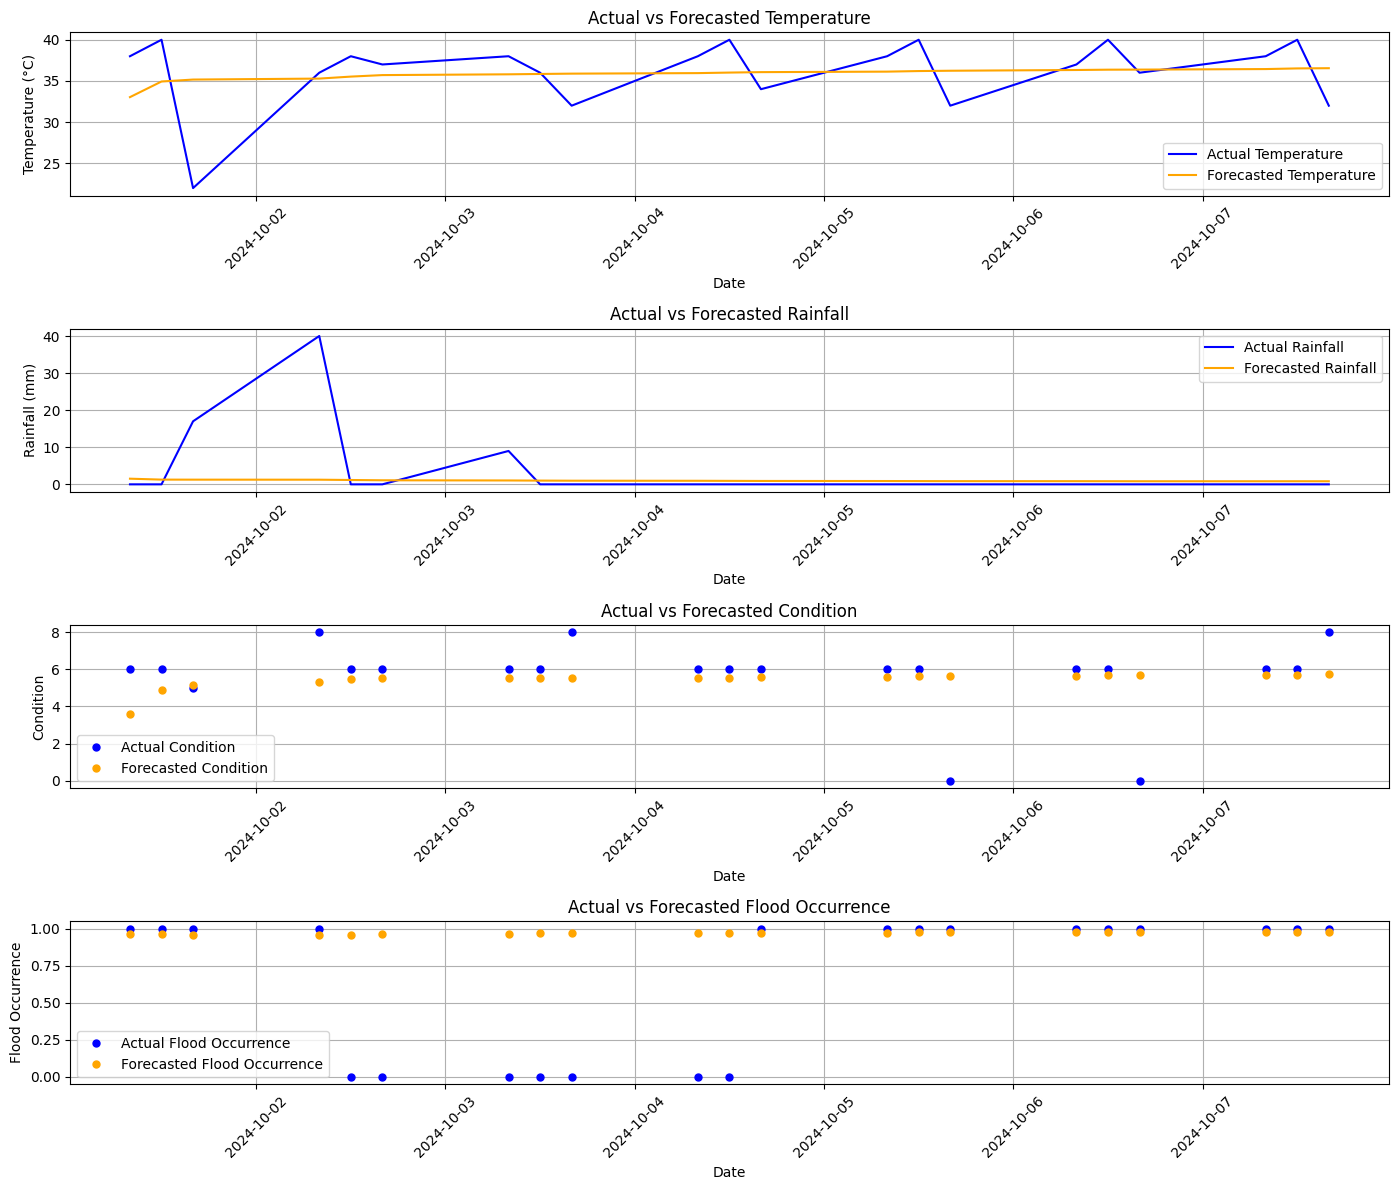

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_results.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_results['DATETIME'] = pd.to_datetime(forecast_results['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_results.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_results.index, forecast_results['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_results.index, forecast_results['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

                     TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
DATETIME                                                                 
2024-10-01 08:00:00         33.037075       1.522786          3.591782   
2024-10-01 12:00:00         34.933975       1.273469          4.891613   
2024-10-01 16:00:00         35.168774       1.263111          5.135427   
2024-10-02 08:00:00         35.286701       1.250936          5.314406   
2024-10-02 12:00:00         35.528225       1.169865          5.458921   
2024-10-02 16:00:00         35.711281       1.091909          5.517552   
2024-10-03 08:00:00         35.805843       1.044138          5.523118   
2024-10-03 12:00:00         35.848583       1.007227          5.515659   
2024-10-03 16:00:00         35.888023       0.977106          5.516348   
2024-10-04 08:00:00         35.951447       0.957489          5.528928   
2024-10-04 12:00:00         36.016659       0.935394          5.549906   
2024-10-04 16:00:00         36.070244 

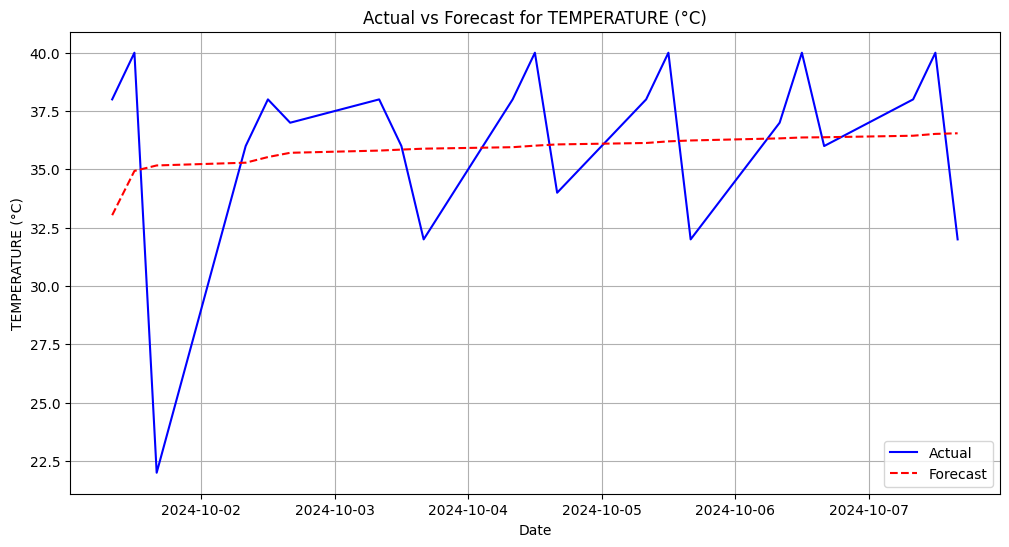

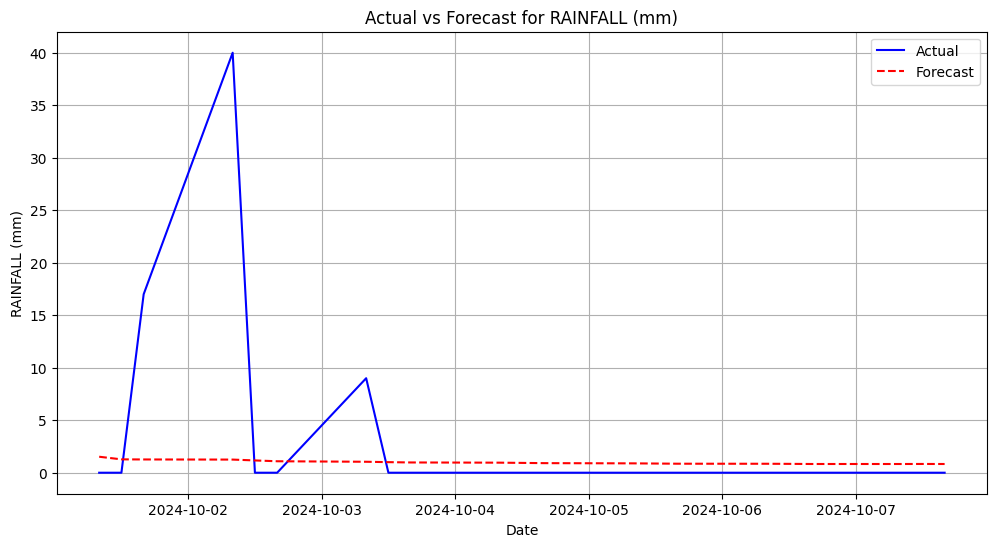

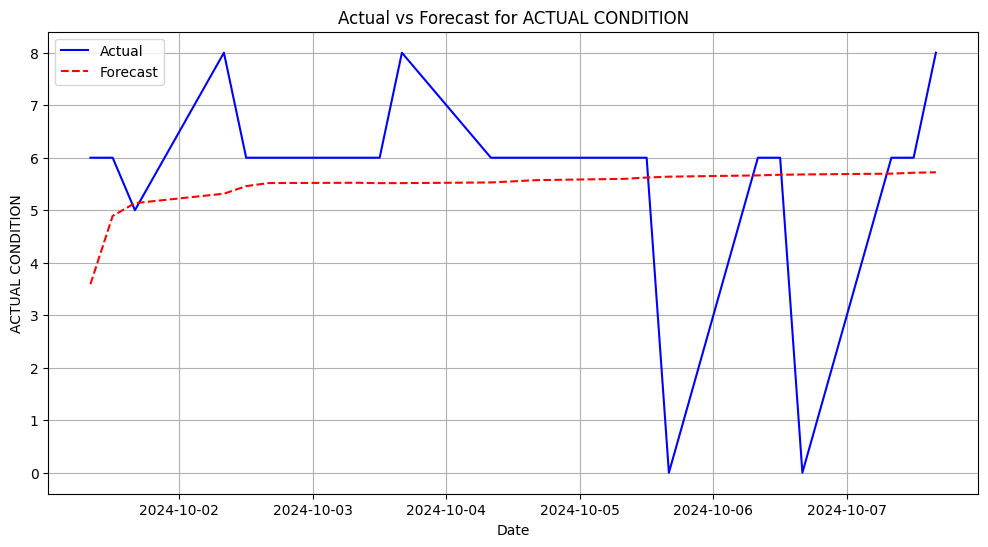

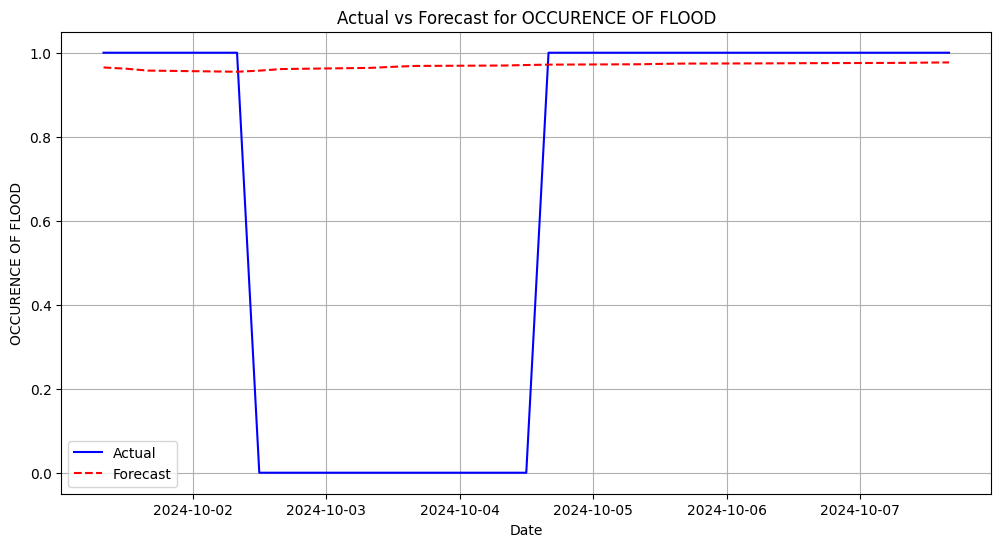

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Convert 'DATETIME' columns to datetime objects for proper plotting and indexing
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])
forecast_results.index = pd.to_datetime(forecast_results.index)
print(forecast_results)

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
#forecast_df.set_index('DATETIME', inplace=True)

# Ensure that the indices align for comparison
common_index = actual_data.index.intersection(forecast_results.index)
actual_data = actual_data.loc[common_index]
forecast_results = forecast_results.loc[common_index]

# Check if the data is aligned properly
if actual_data.empty or forecast_results.empty:
    print("Error: No common indices found between actual and forecast data.")
else:
    # Calculate performance metrics
    metrics = {}
    for column in actual_data.columns:
        if column in forecast_results.columns:
            y_true = actual_data[column]
            y_pred = forecast_results[column]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            metrics[column] = {'MAE': mae, 'RMSE': rmse}
            print(f"{column} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted values for visual comparison
    for column in actual_data.columns:
        if column in forecast_results.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(actual_data.index, actual_data[column], label='Actual', color='blue')
            plt.plot(forecast_results.index, forecast_results[column], label='Forecast', color='red', linestyle='--')
            plt.title(f'Actual vs Forecast for {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()